˙ Mask_rcnn이 감이 안 잡혀서 만들어보는 ResNet </br>
:: 층을 깊게 하는 것이 성능 향상에는 중요, 하지만 너무 깊어도 성능이 떨어지기도 함 </br>
=> 이 문제 해결 위해 스킵 연결(skip connection) 도입 </br>
입력 데이터를 합성곱 계층을 건너뛰어 출력에 바로 더하는 구조 </br>
Keras의 ResNet + 내가 만든 레이어 붙여서 학습 </br>
:: https://rarena.tistory.com/entry/keras-%ED%8A%B9%EC%A0%95-%EB%AA%A8%EB%8D%B8%EB%A1%9C%EB%93%9C%ED%95%98%EC%97%AC-%EB%82%B4-%EB%A0%88%EC%9D%B4%EC%96%B4 참조

In [7]:
%tensorflow_version 1.x

TensorFlow is already loaded. Please restart the runtime to change versions.


In [0]:
# 1. 필요 모듈 import
from keras.applications import ResNet50
from keras.layers import Dense, Input, Activation
from keras.models import Model
from keras.layers.normalization import BatchNormalization
import os, numpy as np
import matplotlib.pyplot as plt
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.optimizers import SGD

In [3]:
# 2. npy 데이터를 불러와서 모델 학습
X_train, X_test, y_train, y_test = np.load("/content/drive/My Drive/fin.npy", allow_pickle=True)
print(f'X_train: {X_train.shape}, y_train: {y_train.shape}')  
print(f'X_test: {X_test.shape}, y_test: {y_test.shape}') 


X_train: (28810, 64, 64, 3), y_train: (28810, 5)
X_test: (7203, 64, 64, 3), y_test: (7203, 5)


In [13]:
# 3. model 생성
input = Input(shape=(64, 64, 3))
model = ResNet50(input_tensor=input, include_top=False, weights=None, pooling='max')
x = model.output
x = Dense(1024, name='fully', init='uniform')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dense(512, init='uniform')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dense(5, activation='softmax')(x)
model = Model(model.input, x)
model.summary()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1024, name="fully", kernel_initializer="uniform")`
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(512, kernel_initializer="uniform")`
  import sys


Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 64, 64, 3)    0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 70, 70, 3)    0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 32, 32, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 32, 32, 64)   256         conv1[0][0]                      
____________________________________________________________________________________________

In [0]:
# 4. 모델 컴파일
model.compile(loss='categorical_crossentropy', optimizer=SGD(lr=0.01, momentum=0.7, clipvalue=0.5), metrics=['accuracy'])

In [16]:
# 5. 모델 학습
model_dir = "./model"
if not os.path.exists(model_dir):
  os.mkdir(model_dir)
model_path = model_dir + '/test.model'
checkpoint = ModelCheckpoint(filepath=model_path, monitor='val_loss', verbose=1, save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=5)
hist = model.fit(X_train, y_train, epochs=100, batch_size=100, callbacks=[checkpoint, early_stopping], validation_split=0.2)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 23048 samples, validate on 5762 samples
Epoch 1/100
23048/23048 [==============================] - 76s 3ms/step - loss: 0.9098 - acc: 0.6470 - val_loss: 0.6742 - val_acc: 0.7280

Epoch 00001: val_loss improved from inf to 0.67421, saving model to ./model/test.model
Epoch 2/100
23048/23048 [==============================] - 49s 2ms/step - loss: 0.4732 - acc: 0.8215 - val_loss: 0.5848 - val_acc: 0.7773

Epoch 00002: val_loss improved from 0.67421 to 0.58481, saving model to ./model/test.model
Epoch 3/100
23048/23048 [==============================] - 49s 2ms/step - loss: 0.3376 - acc: 0.8713 - val_loss: 0.7510 - val_acc: 0.7381

Epoch 00003: val_loss did not improve from 0.58481
Epoch 4/100
23048/23048 [==============================] - 49s 2ms/step - loss: 0.2590 - acc: 0.9024 - val_loss: 0.5249 - val_acc: 0.8181

Epoch 00004: val_loss improved from 0.58481 to 0.52485, saving model t

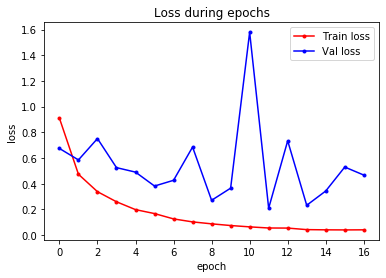

In [17]:
# loss 그래프
train_loss = hist.history['loss']
val_loss = hist.history['val_loss']

x = range(len(train_loss))
plt.plot(x, train_loss, marker='.', color='red', label='Train loss')
plt.plot(x, val_loss, marker='.', color='blue', label='Val loss')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Loss during epochs')
plt.show()

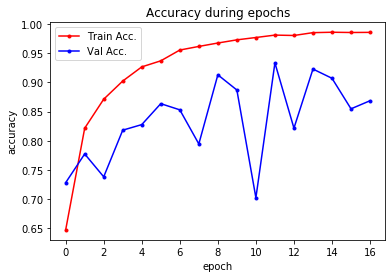

In [18]:
# acc 그래프
train_acc = hist.history['acc']
val_acc = hist.history['val_acc']

plt.plot(x, train_acc, marker='.', c='red', label='Train Acc.')
plt.plot(x, val_acc, marker='.', c='blue', label='Val Acc.')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy during epochs')
plt.show()

In [19]:
# Test set으로 모델 평가
score = model.evaluate(X_test, y_test, verbose=0)
print('Training loss:', score[0])
print('Training accuracy: ', score[1])

Training loss: 0.45137337820407136
Training accuracy:  0.8667221990919901


In [0]:
# 모델 저장하기
from keras.models import load_model
model.save('resnet50_model.h5')

In [21]:
# Confusion Matrix

from sklearn.metrics import confusion_matrix, classification_report
test_true = np.argmax(y_test, axis=1)
print(test_true)
test_pred = np.argmax(model.predict(X_test), axis=1)
print(test_pred)

cm = confusion_matrix(test_true, test_pred)
print(cm)

[3 1 2 ... 2 1 0]
[3 1 2 ... 3 1 0]
[[1079    4   22  283   52]
 [  38 1271   19    8   41]
 [  39   19 1024  303   10]
 [  20    3   83 1409    3]
 [   1    4    2    6 1460]]


In [22]:
# Classification Report
from sklearn.metrics import classification_report
report = classification_report(test_true, test_pred, target_names=os.listdir('/content/drive/My Drive/Final'))
print(report)

              precision    recall  f1-score   support

       nevus       0.92      0.75      0.82      1440
          df       0.98      0.92      0.95      1377
      eschar       0.89      0.73      0.80      1395
          vl       0.70      0.93      0.80      1518
         mel       0.93      0.99      0.96      1473

    accuracy                           0.87      7203
   macro avg       0.88      0.87      0.87      7203
weighted avg       0.88      0.87      0.87      7203

